<a href="https://colab.research.google.com/github/vysf/machine-learning-practice/blob/master/Binary_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
df = pd.read_csv('yelp_labelled.txt', names=['sentence', 'label'], sep='\t')

In [ ]:
df.tail()

,sentence,label
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0
999,"Then, as if I hadn't wasted enough of my life ...",0


In [ ]:
from sklearn.model_selection import train_test_split
kalimat = df['sentence'].values
y = df['label'].values

kalimat_latih, kalimat_test, y_train, y_test = train_test_split(kalimat, y, test_size=0.2)

## Tokenisasi
Proses mengonversi kata-kata ke dalam bilangan numerik dapat kita sebut juga sebagai `tokenisasi`. Tokenisasi dapat dilakukan dengan menggunakan kelas `Tokenizer`. Parameter `num_words` adalah jumlah kata yang akan dikonversi menjadi bilangan numerik, jika `num_words` diatur sebanyak 15, maka hanya 15 kata yang sering muncul yang akan diubah menjadi token. \\
Sedangkan `oov_token` adalah parameter yang berfungsi untuk mengganti kata-kata yang tidak ditokenisasi menjadi karakter tertentu.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

num_words =  250
tokenizer = Tokenizer(num_words=num_words, oov_token='x')

Untuk melakukan tokenisasi, panggil fungsi `fit_on_texts(texts)` pada objek `tokenizer` dengan parameter berupa list teks yang akan ditokenisasi.

In [ ]:
tokenizer.fit_on_texts(kalimat_latih)
tokenizer.fit_on_texts(kalimat_test)

## Sequences
Sebuah `sequences` adalah sebuah larik yang berisi kumpulan token sesuai dengan setiap kata pada sebuah kalimat dalam teks. Untuk membuat `sequence` dari objek `tokenizer` dapat menggunakan fungsi `text_to_sequences(texts)`. Untuk melihat hasil tokenisasi, kita bisa memanggil atribut word_index dari objek tokenizer. Atribut word index mengembalikan dictionary berupa kata sebagai key dan token atau nilai numeriknya sebagai value. Kata-kata yang out-of-vocabulary akan diberi token bernilai 1.

```python
print(tokenizer.word_index)
>>>
{'-': 1, 'programming': 2, 'saya': 3, 'suka': 4, 'sangat': 5, 'menyenangkan': 6, ...}
```

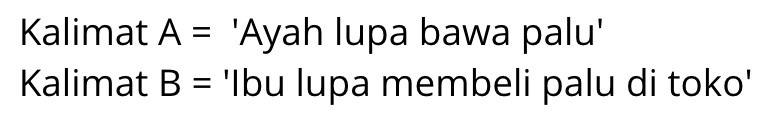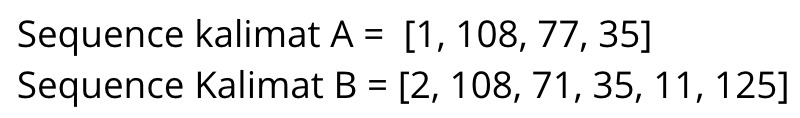 \\

Sama seperti proses klasifikasi gambar, dimana ukuran nilainya harus sama. Maka panjang setiap sequences harulah sama juga.

In [ ]:
sekuens_latih = tokenizer.texts_to_sequences(kalimat_latih)
sekuens_test = tokenizer.texts_to_sequences(kalimat_test)

## Padding
Padding adalah proses yang menyeragamkan panjang setiap sequences dengan menambahkan angka 0 secara suffix atau prefix. Selain itu, padding juga dapat memotong sequences sesuai dengan panjang maksimum. \\
Contoh:
```python
print(tokenizer.texts_to_sequences(['Saya suka programming']))
print(tokenizer.texts_to_sequences(['Saya suka belajar programming sejak SMP']))
>>>
[[3, 4, 2]]
[[3, 4, 1, 1, 1, 1]]
```
kata “Selamat!” dan “SELAMAT” akan diperlakukan sebagai kata yang sama. Hasil dari cell di bawah menunjukkan bahwa kata-kata yang out-of-vocabulary akan diberi token bernilai 1. \\

Pada contoh tersebut, kata "belajar", "sejak", dan "SMP" ditandai dengan nilai "1". Hal ini menunjukkan bahwa kata-kata tersebut tidak terdapat pada dictionary yang sebelumnya telah dibuat (OOV). Tanpa OOV, kata yang tidak memiliki token tidak dimasukkan pada sequence. Jika kita menggunakan OOV, maka setiap kata yang tidak memiliki token akan diberikan token yang seragam. Dengan OOV, informasi urutan setiap kata pada kalimat tidak hilang. \\

Untuk menggunakan padding, kita perlu memanggil library `pad_sequence` terlebih dahulu. Kemudian, panggil fungsi `pad_sequence(sequences)` dan masukkan sequence hasil tokenisasi sebagai parameternya. Setelah melakukan padding, setiap sequence akan memiliki panjang yang sama. Padding dapat melakukan ini dengan menambahkan 0 secara default pada awal sequence yang lebih pendek \\

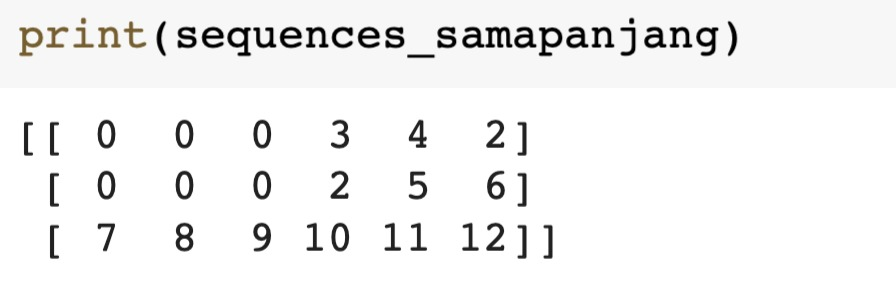

In [ ]:
maxlen = 20
padded_latih = pad_sequences(sekuens_latih, maxlen=maxlen)
padded_test = pad_sequences(sekuens_test, maxlen=maxlen)

Jika kita ingin merubah sehingga 0 ditambahkan di akhir sequence, kita dapat menggunakan parameter padding dengan nilai `post`. Selain itu kita dapat mengatur parameter `maxlen` (panjang maksimum setiap sequence) dengan nilai yang kita inginkan. Jika kita mengisi nilai 5, maka panjang sebuah sequence tidak akan melebihi 5. \\
```python
sequences_samapanjang = pad_sequences(sequences,
                                      padding='post',
                                      maxlen=5)
```
Jika teks kita memiliki panjang lebih dari nilai parameter `maxlen` misalnya 5, maka secara default nilai dari sequence akan diambil 5 nilai terakhir atau 5 kata terakhir saja dari setiap kalimat (mengabaikan kata sebelumnya). Untuk mengubah pengaturan ini dan mengambil 5 kata awal dari tiap kalimat, kita dapat menggunakan parameter `truncating` dan mengisi nilai `post`.
```python
sequences_samapanjang = pad_sequences(sequences,
                                      padding='post',
                                      maxlen=5,
                                      truncating='post')
```

## Embedding
Embedding memungkinkan model ML untuk memahami makna di setiap kata dan mengelompokkan kata-kata dengan makna yang mirip agar berdekatan. Misalnya komentar pada sebuah video youtube, di mana kata-kata “menarik”, “keren”, dan “luar biasa” akan dikelompokkan berdekatan. Pengelompokkan ini dapat dicapai dengan memetakan setiap kata ke dalam vektor atau larik. Di mana kata yang mirip akan memiliki nilai vektor yang mirip.  \\

Untuk mengimplementasikan Embedding pada Keras juga sangatlah mudah. Pada model sequential, kita tinggal memanggil fungsi `Embedding(jumlah_kata, dimensi_embedding, panjang_input)` dan mengisi parameter total kata yang di tokenisasi, panjang kalimat, serta dimensi embedding yang diinginkan. Karena hasil dari embedding merupakan larik 2 dimensi yang berisi panjang setiap kalimat, dan dimensi embedding, maka kita memerlukan fungsi `flatten()`.

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, 16, input_length=maxlen),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
num_epocs = 30
history = model.fit(
    padded_latih,
    y_train,
    epochs=num_epocs,
    validation_data=(padded_test, y_test),
    verbose=2
)

Epoch 1/30
25/25 - 5s - loss: 0.6929 - accuracy: 0.4975 - val_loss: 0.6910 - val_accuracy: 0.5450 - 5s/epoch - 182ms/step
Epoch 2/30
25/25 - 1s - loss: 0.6908 - accuracy: 0.5450 - val_loss: 0.6890 - val_accuracy: 0.5700 - 725ms/epoch - 29ms/step
Epoch 3/30
25/25 - 0s - loss: 0.6875 - accuracy: 0.5713 - val_loss: 0.6853 - val_accuracy: 0.5800 - 462ms/epoch - 18ms/step
Epoch 4/30
25/25 - 0s - loss: 0.6816 - accuracy: 0.6200 - val_loss: 0.6791 - val_accuracy: 0.6100 - 412ms/epoch - 16ms/step
Epoch 5/30
25/25 - 0s - loss: 0.6709 - accuracy: 0.6438 - val_loss: 0.6681 - val_accuracy: 0.6300 - 418ms/epoch - 17ms/step
Epoch 6/30
25/25 - 0s - loss: 0.6551 - accuracy: 0.6850 - val_loss: 0.6535 - val_accuracy: 0.6750 - 312ms/epoch - 12ms/step
Epoch 7/30
25/25 - 0s - loss: 0.6306 - accuracy: 0.7325 - val_loss: 0.6336 - val_accuracy: 0.6950 - 489ms/epoch - 20ms/step
Epoch 8/30
25/25 - 1s - loss: 0.5996 - accuracy: 0.7800 - val_loss: 0.6116 - val_accuracy: 0.6900 - 569ms/epoch - 23ms/step
Epoch 9/30

In [ ]:
import numpy as np

input = "Appetite instanly gone."
label = 0
input_np = np.array([input])
input_tk = tokenizer.texts_to_sequences(input_np)
input_pd = pad_sequences(input_tk)

# output = model.predict(np.array([padded_test[20]]))
output = model.predict(input_pd)
prob = np.round(np.max(output)*100, 2)
label = np.argmax(output)
print(label, prob)

model.evaluate(input_pd, np.array([label]))

1/1 [==============================] - 0s 23ms/step
0 1.18
1/1 [==============================] - 0s 31ms/step - loss: 0.0118 - accuracy: 1.0000


[0.01183531153947115, 1.0]

In [ ]:
idx = 20
input = np.array([padded_test[idx]])
output = np.array([y_test[idx]])
model.evaluate(input, output)


output = model.predict(input)
prob = np.round(np.max(output)*100, 2)
label = np.argmax(output)
print(label, prob)

1/1 [==============================] - 0s 20ms/step
0 82.37
